In [36]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, LSTM, Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from keras import layers


Importing the data

In [46]:
df=pd.read_csv("Spam_SMS.csv")
df=df.dropna()
df

,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...
5570,ham,Will ü b going to esplanade fr home?
5571,ham,"Pity, * was in mood for that. So...any other s..."
5572,ham,The guy did some bitching but I acted like i'd...


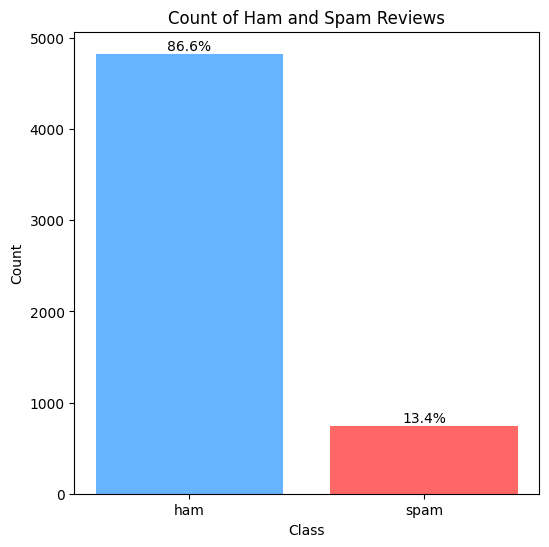

In [15]:
label_counts = df['Class'].value_counts()

# Calculate percentages
total = label_counts.sum()
percentages = (label_counts / total) * 100

# Create a bar plot
plt.figure(figsize=(6, 6))
bars = plt.bar(['ham', 'spam'], label_counts, color=['#66b3ff', '#ff6666'])

# Add percentage labels on top of each bar
for bar, percentage in zip(bars, percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x-coordinate: center of the bar
        bar.get_height(),  # y-coordinate: top of the bar
        f'{percentage:.1f}%',  # label with one decimal place
        ha='center',  # horizontal alignment
        va='bottom'   # vertical alignment
    )

plt.title('Count of Ham and Spam Reviews')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [ ]:
X = df.drop('Class', axis=1)
y = df['Class']

(5574, 1)

In [108]:
text_vec_layer = tf.keras.layers.TextVectorization(split = "character", standardize = "lower",output_sequence_length = 910)
text_vec_layer.adapt(X)

n_tokens = text_vec_layer.vocabulary_size() #0 = padding, 1 = unknown
print("Total chars:", n_tokens)

X_vectorized = text_vec_layer(X)
np.shape(X_vectorized)

Total chars: 85


TensorShape([5574, 910])

In [48]:
y

0        ham
1        ham
2       spam
3        ham
4        ham
        ... 
5569    spam
5570     ham
5571     ham
5572     ham
5573     ham
Name: Class, Length: 5574, dtype: object

In [30]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y) 
y[:4]

array([0, 0, 1, 0])

In [ ]:
# Define embedding vector features
embedding_vector_features = 30

# Create a simple sequential model
model = Sequential()

# Embedding layer
model.add(Embedding(n_tokens, embedding_vector_features,))

# Single LSTM layer
model.add(LSTM(64))  # Using fewer units

# Dropout layer to prevent overfitting
model.add(Dropout(0.3))  # Lower dropout rate

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

In [33]:
X_final=np.array(X_vectorized)
y_final=np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.25, random_state=42,shuffle = True)

In [34]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=20, batch_size=32, 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 64s 434ms/step - accuracy: 0.8587 - loss: 0.4595 - val_accuracy: 0.8630 - val_loss: 0.4001 - learning_rate: 0.0010
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 311ms/step - accuracy: 0.8741 - loss: 0.3819 - val_accuracy: 0.8630 - val_loss: 0.4004 - learning_rate: 0.0010
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 318ms/step - accuracy: 0.8630 - loss: 0.4044 - val_accuracy: 0.8630 - val_loss: 0.3997 - learning_rate: 0.0010
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 313ms/step - accuracy: 0.8709 - loss: 0.3922 - val_accuracy: 0.8630 - val_loss: 0.4004 - learning_rate: 0.0010
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 315ms/step - accuracy: 0.8686 - loss: 0.3899 - val_accuracy: 0.8630 - val_loss: 0.3998 - learning_rate: 0.0010
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 318ms/step - accuracy: 0.8617 - loss: 0.4059 - val_accuracy: 0.8630 - val_loss: 0.4001 - learning_rate: 2.0000e-04
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 288ms/step - accuracy:

In [38]:
batch_size = 128

embed = tf.keras.Sequential([
    layers.Embedding(input_dim = n_tokens, output_dim = 30, mask_zero=True)
])

rnn = tf.keras.Sequential([
    layers.GRU(128),
    layers.Dense(1, activation="sigmoid")
])

model = tf.keras.Sequential([embed,rnn])

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])

epochs = 10
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
es = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)




In [39]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=epochs, batch_size=32, 
                    callbacks=[lr, es])

Epoch 1/10


C:\Users\fisch\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\layer.py:877: UserWarning: Layer 'sequential_2' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


131/131 ━━━━━━━━━━━━━━━━━━━━ 125s 906ms/step - accuracy: 0.9130 - loss: 0.2428 - val_accuracy: 0.9735 - val_loss: 0.1011 - learning_rate: 0.0100
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 110s 828ms/step - accuracy: 0.9681 - loss: 0.1256 - val_accuracy: 0.9749 - val_loss: 0.0840 - learning_rate: 0.0100
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.9770 - loss: 0.0820 - val_accuracy: 0.9806 - val_loss: 0.0735 - learning_rate: 0.0100
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 93s 711ms/step - accuracy: 0.9810 - loss: 0.0723 - val_accuracy: 0.9778 - val_loss: 0.0694 - learning_rate: 0.0100
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 93s 710ms/step - accuracy: 0.9816 - loss: 0.0653 - val_accuracy: 0.9821 - val_loss: 0.0710 - learning_rate: 0.0100
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 93s 711ms/step - accuracy: 0.9798 - loss: 0.0722 - val_accuracy: 0.9799 - val_loss: 0.0772 - learning_rate: 0.0100
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 89s 681ms/step - accuracy: 0.9827 - loss:

In [ ]:
def predict(text):
    text_vector = text_vec_layer(pd.DataFrame([text]))
    print(np.shape(text_vector))
    prediction = model.predict(text_vector)
    print(prediction)
    if prediction[0] > 0.5:
        return "Spam"
    else:
        return "Not Spam"

predict('Free entry, Text FA to 87121 to receive entry question(std txt rate)'), predict('I miss you')
    

(1, 910)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[[0.8903811]]
(1, 910)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[[0.00147145]]


('Spam', 'Not Spam')

In [84]:
predictions = model.predict(X_test)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.9867 - loss: 0.0497
Test Accuracy: 0.9835007190704346


In [112]:
np.array(X)[2]

array(["Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"],
      dtype=object)